<a href="https://colab.research.google.com/github/hardik0/Multi-Object-Tracking-Google-Colab/blob/main/Towards-Realtime-MOT-Vehicle-Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Towards Realtime MOT - Vehicle Tracking
Joint Detection and Embedding (JDE) model. JDE is a fast and high-performance multiple-object tracker that learns the object detection task and appearance embedding task simutaneously in a shared neural network. Techical details are described in [ECCV 2020 paper](https://arxiv.org/pdf/1909.12605v1.pdf). 

**Original code (Pedestrian):** [Towards-Realtime-MOT](https://github.com/Zhongdao/Towards-Realtime-MOT) by [@ZhongdaoWang](https://github.com/Zhongdao)

**[Modified version] Vehicle tracking code (UA-DETRAC):** [Towards-Realtime-MOT:detrac](https://github.com/hardik0/Towards-Realtime-MOT/tree/detrac)

### Citation
```
@article{wang2019towards,
  title={Towards Real-Time Multi-Object Tracking},
  author={Wang, Zhongdao and Zheng, Liang and Liu, Yixuan and Wang, Shengjin},
  journal={arXiv preprint arXiv:1909.12605},
  year={2019}
}
```

In [ ]:
! nvidia-smi
! /usr/local/cuda/bin/nvcc --version

To access Google Drive Folder and Files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Installation
clone this repository

In [ ]:
#! git clone https://github.com/hardik0/Towards-Realtime-MOT
! git clone -b detrac https://github.com/hardik0/Towards-Realtime-MOT
%cd Towards-Realtime-MOT

Cloning into 'Towards-Realtime-MOT'...
remote: Enumerating objects: 407, done.
remote: Total 407 (delta 0), reused 0 (delta 0), pack-reused 407
Receiving objects: 100% (407/407), 21.42 MiB | 50.41 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/Towards-Realtime-MOT


check torch version

In [ ]:
import torch
torch.__version__

'1.7.0+cu101'

Downgrade the PyTorch version to 1.2

In [ ]:
# uncomment below line ONLY if you run into any dependency issues while following
#! pip install torch==1.2.0 torchvision==0.4.0

In [ ]:
import torch
torch.__version__

Install the Dependencies

In [ ]:
! pip install motmetrics cython_bbox ffmpeg lap pillow

restart the runtime if required

In [ ]:
# change dir after restart
%cd Towards-Realtime-MOT/

/content/Towards-Realtime-MOT


## Dataset preparation

### Download DETRAC dataset

In [ ]:
%%shell

wget -O DETRAC-train-data.zip http://detrac-db.rit.albany.edu/Data/DETRAC-train-data.zip
#wget -O DETRAC-test-data.zip http://detrac-db.rit.albany.edu/Data/DETRAC-test-data.zip
wget -O DETRAC-Train-Annotations-XML.zip http://detrac-db.rit.albany.edu/Data/DETRAC-Train-Annotations-XML.zip
mkdir data/MOT
unzip -q DETRAC-train-data.zip -d data/
#unzip -q DETRAC-test-data.zip -d data/
unzip -q DETRAC-Train-Annotations-XML.zip -d data/
#rm -r *.zip

### Data Format
All the datasets have the following structure:

```
Caltech
   |——————images
   |        └——————00001.jpg
   |        |—————— ...
   |        └——————0000N.jpg
   └——————labels_with_ids
            └——————00001.txt
            |—————— ...
            └——————0000N.txt
```

Every image has a corresponding annotation text. Given an image path, the annotation text path can be generated by replacing the string `images` with `labels_with_ids` and replacing `.jpg` with `.txt`.

In the annotation text, each line is describing a bounding box and has the following format:

`[class] [identity] [x_center] [y_center] [width] [height]`

The field `[class]` should be `0`. Only single-class multi-object tracking is supported in this version.

The field `[identity]` is an integer from `0` to `num_identities - 1`, or `-1` if this box has no identity annotation.

***Note** that the values of `[x_center] [y_center] [width] [height]` are normalized by the width/height of the image, so they are floating point numbers ranging from 0 to 1.

Script to convert DETRAC tracking dataset to MOT format

In [ ]:
# will take about 25-30 minutes 
! python gen_labels_detrac.py > gen_labels_detrac.log 2>&1
#! python gen_labels_detrac.py

In [ ]:
! tail gen_labels_detrac.log

In [ ]:
! head data/detrac.train

DETRAC/images/train/MVI_20011/img1/img00001.jpg
DETRAC/images/train/MVI_20011/img1/img00002.jpg
DETRAC/images/train/MVI_20011/img1/img00003.jpg
DETRAC/images/train/MVI_20011/img1/img00004.jpg
DETRAC/images/train/MVI_20011/img1/img00005.jpg
DETRAC/images/train/MVI_20011/img1/img00006.jpg
DETRAC/images/train/MVI_20011/img1/img00007.jpg
DETRAC/images/train/MVI_20011/img1/img00008.jpg
DETRAC/images/train/MVI_20011/img1/img00009.jpg
DETRAC/images/train/MVI_20011/img1/img00010.jpg


In [ ]:
! du -shc data/MOT/DETRAC/*

9.2G	data/MOT/DETRAC/images
324M	data/MOT/DETRAC/labels_with_ids
9.5G	total


Remove unnecessary files(optional)

In [ ]:
#%rm -r DETRAC-train-data.zip
%rm -r data/Insight-MVT_Annotation_Train
%rm -r data/DETRAC-Train-Annotations-XML

zip processed dataset for further use

In [ ]:
%%shell

cd data/MOT
zip -qr DETRAC.zip DETRAC/

copy zip file to gdrive

In [ ]:
! cp -r data/MOT/DETRAC.zip '../gdrive/My Drive/Colab Notebooks/MOT/'

In [ ]:
! ls '../gdrive/My Drive/Colab Notebooks/MOT/'

copy dataset from google drive | using google_utils script 

In [ ]:
! cp -r '../gdrive/My Drive/Colab Notebooks/MOT/DETRAC.zip' data/

Share files from Google Drive check [this](https://support.google.com/drive/answer/2494822?co=GENIE.Platform%3DDesktop&hl=en) page & copy File ID

In [ ]:
! wget -O utils/google_utils.py https://raw.githubusercontent.com/hardik0/Multi-Object-Tracking-Google-Colab/main/utils/google_utils.py
from utils.google_utils import *
#gdrive_download(id='{google_drive_File_ID}', name='path_to/DETRAC.zip')
gdrive_download(id='', name='data/DETRAC.zip')

unzip DETRAC.zip file to `data/MOT`

In [ ]:
%%shell

mkdir data/MOT
cd data/MOT
unzip -q ../DETRAC.zip
rm -r ../DETRAC.zip

In [ ]:
# uncomment below lines to train model with different resolutions
#! rm -r  cfg/yolov3_detrac.cfg    # default yolov3_1088x608
#! cp cfg/yolov3_1088x608.cfg cfg/yolov3_detrac.cfg

`cfg/detrac.json` file is already created if you change/modify something then create again (optional)

In [ ]:
%rm -r cfg/detrac.json
%%writefile cfg/detrac.json
{
    "root":"/content/Towards-Realtime-MOT/data/MOT",
    "train":
    {
        "detrac":"./data/detrac.train"
    },
    "test_emb":
    {
        "detrac":"./data/detrac.train"
    },
    "test":
    {
        "detrac":"./data/detrac.train"
    }
}

Writing cfg/detrac.json


make directory on gdrive to save training model

In [ ]:
#%mkdir '../gdrive/My Drive/Colab Notebooks/MOT'
%mkdir '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT'
%ls '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/'

Download Darknet-53 ImageNet pretrained model: [DarkNet Official](https://pjreddie.com/media/files/darknet53.conv.74) | or download from gdrive

In [ ]:
%mkdir weights
! cp -r '../gdrive/My Drive/Colab Notebooks/MOT/darknet53.conv.74' weights/

## Start the Training

In [ ]:
# training 

#! CUDA_VISIBLE_DEVICES=0 python train.py 
! CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch train.py \
                                --cfg cfg/yolov3_detrac.cfg --data-cfg cfg/detrac.json \
                                --batch-size 6 --print-interval 1000 --save-model-after 2 \
                                --weights-to '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/' 
                               # --resume --weights-from '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/run12_10_09_15/'  

In [ ]:
%ls '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/'

 ### Resume training

In [ ]:
# resume training 

#! CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch train.py \
! CUDA_VISIBLE_DEVICES=0 python train.py --cfg cfg/yolov3.cfg --data-cfg cfg/detrac.json \
                                         --batch-size 6 --print-interval 1000 --save-model-after 2 \
                                         --weights-to '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/' \
                                         --resume --weights-from '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/run12_10_09_15/' 

dataset summary
OrderedDict([('detrac', 5984.0)])
total # identities: 5985
start index
OrderedDict([('detrac', 0)])
2020-10-14 06:22:35 [INFO]:    Epoch       Batch       box      conf        id     total  nTargets      time
2020-10-14 06:22:44 [INFO]:     2/29     0/13679     0.634    0.0464      11.7     -4.17        66      9.45
2020-10-14 06:44:06 [INFO]:     2/29  1000/13679     0.927     0.027      17.9     -5.13      42.5     0.656
2020-10-14 07:05:37 [INFO]:     2/29  2000/13679      0.65    0.0262      17.9     -4.52      42.4     0.654
2020-10-14 07:27:10 [INFO]:     2/29  3000/13679     0.649     0.026      17.9     -4.41      42.4     0.656
2020-10-14 07:48:47 [INFO]:     2/29  4000/13679     0.563    0.0254      17.9     -1.62      42.4     0.664
2020-10-14 08:10:26 [INFO]:     2/29  5000/13679     0.489    0.0249      17.8        -2      42.3     0.664
2020-10-14 08:32:07 [INFO]:     2/29  6000/13679     0.648    0.0247      17.7     -2.03      42.4     0.669
2020-10-14 0

In [ ]:
%ls '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/run14_10_06_21/'

cfg/  latest.pt  weights_epoch_2.pt


copy weight file from gdrive to `model/` directory

In [ ]:
%mkdir models
%cp -r '../gdrive/My Drive/Colab Notebooks/MOT/Towards_Realtime_MOT/run14_10_06_21/latest.pt' models/

## Inference

### Download video from Youtube | Copy video from Google Drive

     |████████████████████████████████| 1.8MB 6.5MB/s 


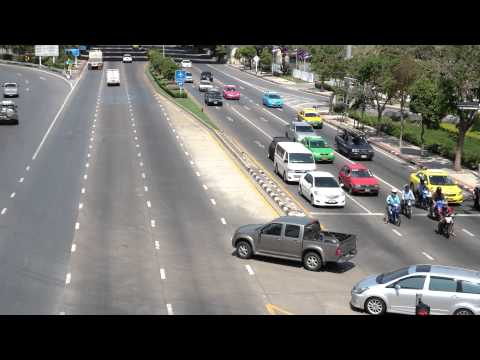

In [ ]:
!pip install youtube-dl
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'jjlBnrzSGjc'

YouTubeVideo(YOUTUBE_ID)

In [ ]:
#!rm -rf youtube.mp4
# download the youtube with the given ID
! youtube-dl -f 22 --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
#!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

# cut the first 30 seconds
! ffmpeg -y -loglevel info -i youtube.mp4 -t 30 car.mp4

### Run the demo

In [ ]:
# line 163 - nID=5985 (if you get any nID error modify 163 line from file browser)
! python demo.py --input-video car.mp4 --weights models/latest.pt --cfg cfg/yolov3_detrac.cfg --output-format video --output-root outputs/detrac_car_tracking

In [ ]:
%ls outputs/detrac_car_tracking/

frame/  result.avi  result.mp4  results.txt


rename result.mp4 file (optional)

In [ ]:
%mv outputs/detrac_car_tracking/result.mp4 outputs/detrac_car_tracking/detrac_car.mp4 

Reduce video size (optional)

In [ ]:
! ffmpeg -y -loglevel panic -i outputs/detrac_car_tracking/detrac_car.mp4 outputs/detrac_car_tracking/detrac_car_tracking_jde_1088X608_result.mp4

Copy video to google drive | download video from file browser (optional)

In [ ]:
%cp -r outputs/detrac_car_tracking/detrac_car_tracking_jde_1088X608_result.mp4 '../gdrive/My Drive/Colab Notebooks/MOT/'

Playing videos on google colab

In [ ]:
# define helper function to display videos
import io 
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width="{0}" controls>
        <source src="{1}" type="video/mp4">
  </video>
  """.format(width, data_url))